In [1]:
import pyflann as fl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import matplotlib.image as mpimg

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read the data and shape them accordingly
vec = np.fromfile('../data/oxford_105k/imgdesc105k.dat', dtype=np.float32)
points = vec.reshape(-1, 128)
print(points.shape)

names = pd.read_csv('../data/oxford_105k/imagenames105k.txt', header=None)

(104933, 128)


In [50]:
flann = fl.FLANN()

""" Autotune results
{'algorithm': 'kmeans', 'checks': 752, 'eps': 0.0, 'sorted': 1, 'max_neighbors': -1, 'cores': 0, 
'trees': 1, 'leaf_max_size': 4, 'branching': 32, 'iterations': 10, 'centers_init': 'random', 
'cb_index': 0.20000000298023224, 'target_precision': 0.8999999761581421, 'build_weight': 0.009999999776482582, 
'memory_weight': 0.0, 'sample_fraction': 0.10000000149011612, 'table_number_': 12, 'key_size_': 20, 
'multi_probe_level_': 2, 'log_level': 'info', 'random_seed': 192396729, 'speedup': 31.920970916748047}

"""
#params = flann.build_index(points, algorithm="autotuned", target_precision=0.9, log_level = "info")
#print("Using params for k-NN:", params)
start = time.time()
params = {'algorithm': 'kmeans', 'checks': 752, 'eps': 0.0, 'sorted': 1, 'max_neighbors': -1, 'cores': 0, 
'trees': 1, 'leaf_max_size': 4, 'branching': 32, 'iterations': 10, 'centers_init': 'random', 
'cb_index': 0.20000000298023224, 'target_precision': 0.8999999761581421, 'build_weight': 0.009999999776482582, 
'memory_weight': 0.0, 'sample_fraction': 0.10000000149011612, 'table_number_': 12, 'key_size_': 20, 
'multi_probe_level_': 2, 'log_level': 'info', 'random_seed': 192396729}

flann.build_index(points, **params)
index_time = time.time() - start
print("Time to build index with FLANN: ", index_time)

Time to build index with FLANN:  11.771403551101685


In [14]:
flann.save_index('flann_index')

In [30]:
# Recall@K based on the Kgraph paper
def eval (gold, result):
    assert gold.shape == result.shape
    N = gold.shape[0]
    K = gold.shape[1]
    total = 0
    for i in range(N):
        total += len(set(gold[i]).intersection(result[i]))
    return 1.0 * total / (N * K)

# Recall@K based on the PQ paper
def eval2(gold, result):
    assert gold.shape == result.shape
    N = gold.shape[0]
    K = gold.shape[1]
    total = 0
    for i in range(N):
        if gold[i][0] in result[i]:
            total += 1 
    return 1.0 * total / N

K=1000
dataset = points
N = points.shape[0]
Q = 1000
D = points.shape[1]


np.random.seed(1234)
idx = np.random.randint(0, N, Q)
query = dataset[idx]

gold = None
print("Generating gold standard from sklearn...")
nbrs = NearestNeighbors(n_neighbors=1000, algorithm='brute').fit(dataset)
distances, gold = nbrs.kneighbors(query)

Generating gold standard from sklearn...


In [42]:
start = time.time()
flann = fl.FLANN()
flann.load_index('flann_index', dataset)
index_time = time.time() - start
print("Time to load index: ", index_time)

start = time.time()
flann.nn_index(query, 5)
search_time = time.time() - start
print("Querying 1000 datapoints using K=5: ", search_time)

Time to load index:  0.023205041885375977
Querying 1000 datapoints using K=5:  0.03713703155517578


[0.404, 0.34875, 0.2937777777777778, 0.23621052631578948, 0.20286206896551723, 0.2133469387755102, 0.24881818181818183, 0.3064176706827309, 0.3591382765531062, 0.41496696696696694]


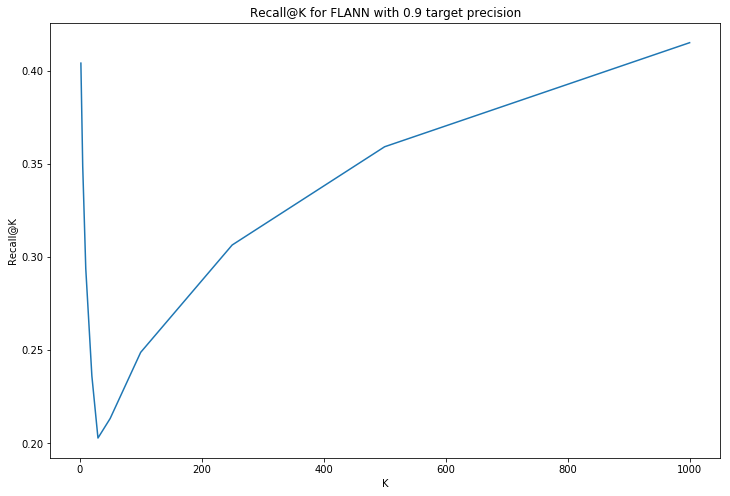

In [31]:
#flann.build_index(points, **params)

recalls_flann=[]
kappas = [2, 5, 10, 20, 30, 50, 100, 250, 500, 1000]
for k in kappas:
    result, dists = flann.nn_index(query, k)
    recalls_flann.append(eval(gold[:, 1:k], result[:, 1:]))

print(recalls_flann)

plt.figure(figsize=(12,8))
plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Recall@K for FLANN with 0.9 target precision")
plt.plot(kappas, recalls_flann)

In [32]:
#flann.build_index(points, **params)
flann.load_index('flann_index', dataset)

recalls_flann2=[]
kappas = [2, 5, 10, 20, 30, 50, 100, 250, 500, 1000]
for k in kappas:
    result, dists = flann.nn_index(query, k)
    recalls_flann2.append(eval2(gold[:, 1:k], result[:, 1:]))

In [33]:
recalls_flann2

[0.404, 0.404, 0.404, 0.404, 0.404, 0.47, 0.578, 0.704, 0.816, 0.899]

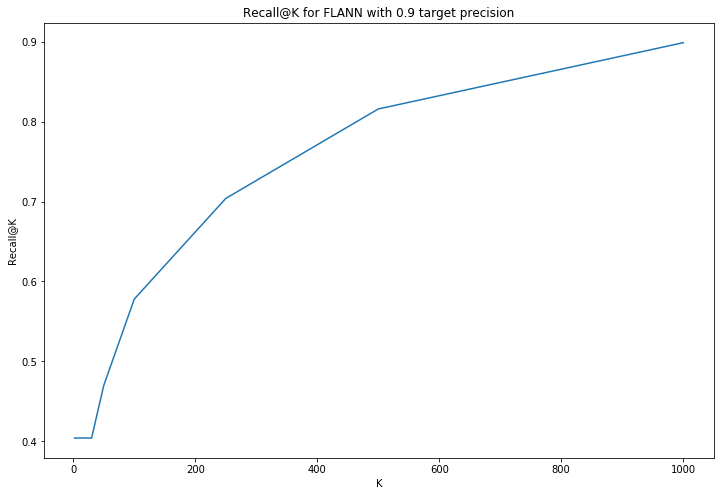

In [34]:
plt.figure(figsize=(12,8))
plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Recall@K for FLANN with 0.9 target precision")
plt.plot(kappas, recalls_flann2)

## PQ method

In [10]:
import faiss

In [44]:
d = 128
m = 8
n_bits = 8

start = time.time()
pq = faiss.IndexPQ(d, m, n_bits)
pq.train(dataset)
pq.add(dataset)
build_index_time = time.time() - start
print("Time to build index with PQ: ", build_index_time)

Time to build index with PQ:  5.9112868309021


In [45]:
start = time.time()
D, I = pq.search (query, 5)
search_time = time.time() - start
print("Querying 1000 datapoints using PQ and K=5: ", search_time)

Querying 1000 datapoints using PQ and K=5:  0.34407520294189453


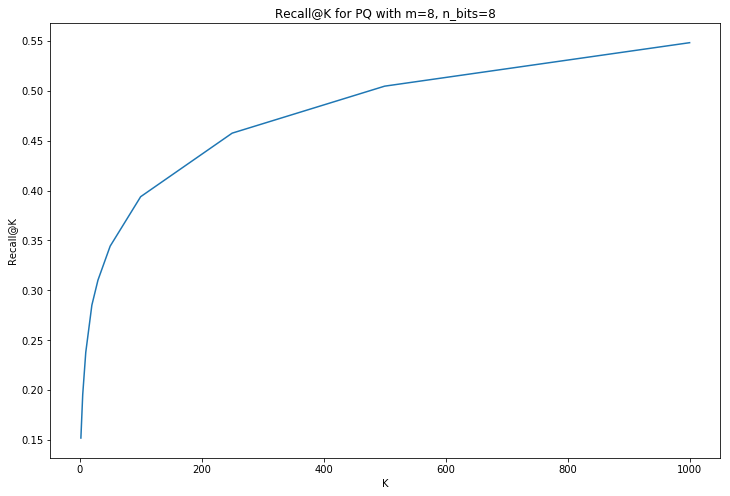

In [35]:
recalls_pq=[]
kappas = [2, 5, 10, 20, 30, 50, 100, 250, 500, 1000]
for k in kappas:
    dists, result = pq.search (query, k)
    recalls_pq.append(eval(gold[:, 1:k], result[:, 1:]))

plt.figure(figsize=(12,8))
plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Recall@K for PQ with m=8, n_bits=8")
plt.plot(kappas, recalls_pq)

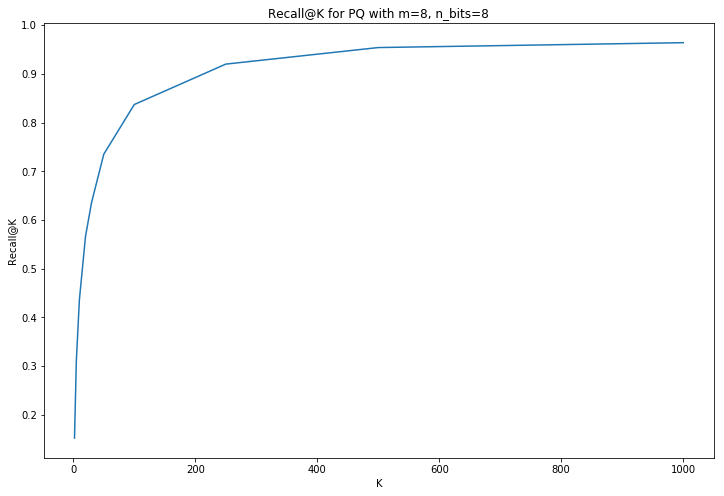

In [36]:
recalls_pq2=[]
kappas = [2, 5, 10, 20, 30, 50, 100, 250, 500, 1000]
for k in kappas:
    dists, result = pq.search(query, k)
    recalls_pq2.append(eval2(gold[:, 1:k], result[:, 1:]))

plt.figure(figsize=(12,8))
plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Recall@K for PQ with m=8, n_bits=8")
plt.plot(kappas, recalls_pq2)

In [37]:
recalls_pq2

[0.152, 0.311, 0.436, 0.566, 0.636, 0.735, 0.837, 0.92, 0.954, 0.964]

## Query FLANN

The neighbours of 1100 are: [   739   2323   1292 102350    882]
['christ_church_000844']
['christ_church_000090']
['magdalen_001151']
['cornmarket_000136']
['0019/wedding_003040']
['christ_church_000339']


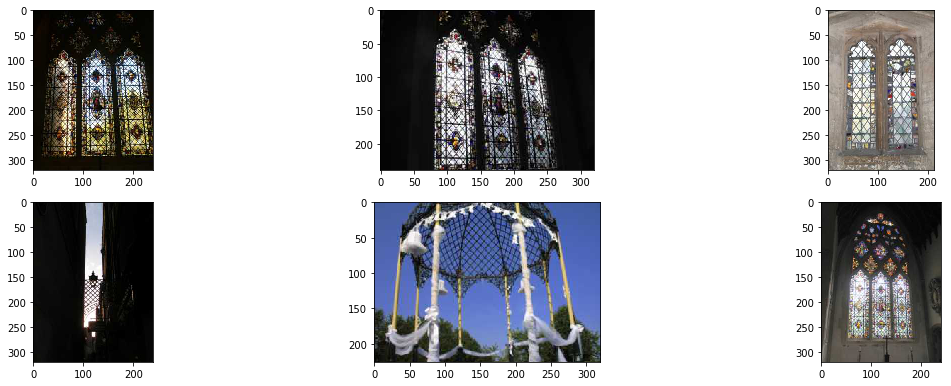

In [51]:
query = points[1100, :]


#flann.search(query.reshape(-1, 128), K=6)
result, dists = flann.nn_index(query, 6)

print("The neighbours of", result[0][0], "are:",  result[0][1:])

images = []
for r in result[0]:
    print(names.values[r])
    img_path = '../data/oxford_105k/oxc-complete/' + names.values[r][0] + '.jpg'
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 3
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)


## Query PQ from FAISS

The neighbours of 739 are: [  1100 102350   1597  15160   2323]
['christ_church_000090']
['christ_church_000844']
['0019/wedding_003040']
['keble_000172']
['0002/beach_002840']
['magdalen_001151']


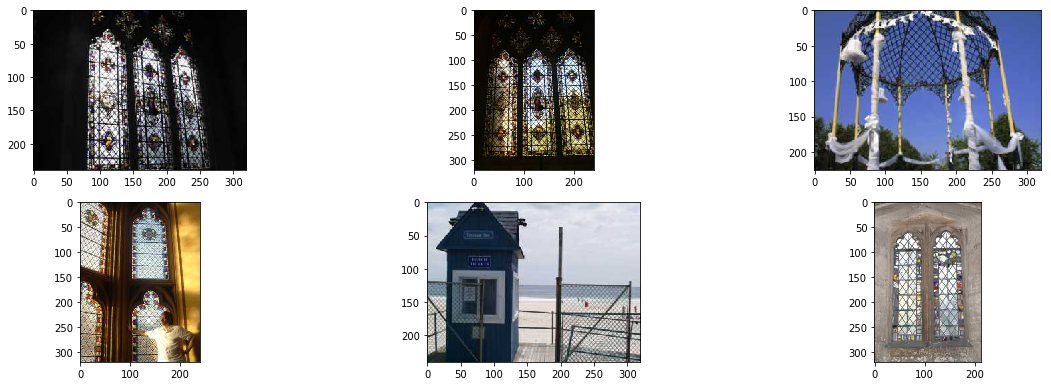

In [52]:
query = points[1100, :]


#flann.search(query.reshape(-1, 128), K=6)
dists, result = pq.search(query.reshape(-1, 128), 6)

print("The neighbours of", result[0][0], "are:",  result[0][1:])

images = []
for r in result[0]:
    print(names.values[r])
    img_path = '../data/oxford_105k/oxc-complete/' + names.values[r][0] + '.jpg'
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 3
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)


## Graphical comparison

In [21]:
# From the Kgraph notebook
[0.959,
 0.98625,
 0.9895555555555555,
 0.992,
 0.991551724137931,
 0.9901428571428571,
 0.9875555555555555,
 0.9877911646586346,
 0.9883807615230461,
 0.9891161161161162]
recalls_kgraph2=[0.959, 0.972, 0.973, 0.974, 0.974, 0.976, 0.976, 0.977, 0.978, 0.98]

### Method comparison using the Recall@K definition from the KGraph paper

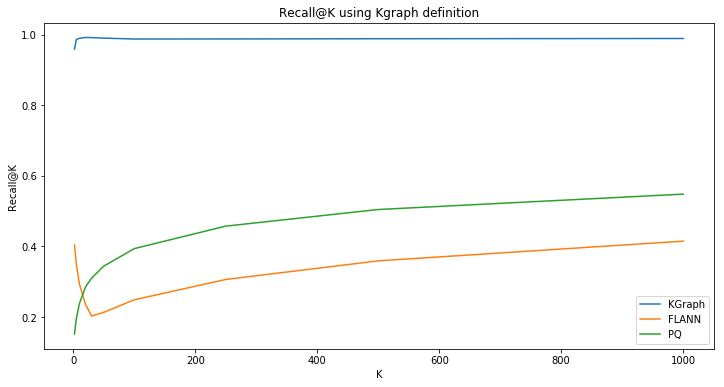

In [38]:
plt.figure(figsize=(12,6))
plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Recall@K using Kgraph definition")
plt.plot(kappas, recalls_kgraph, label='KGraph')
plt.plot(kappas, recalls_flann, label='FLANN')
plt.plot(kappas, recalls_pq, label='PQ')
plt.legend()

### Method comparison using the Recall@K definition from the PQ paper

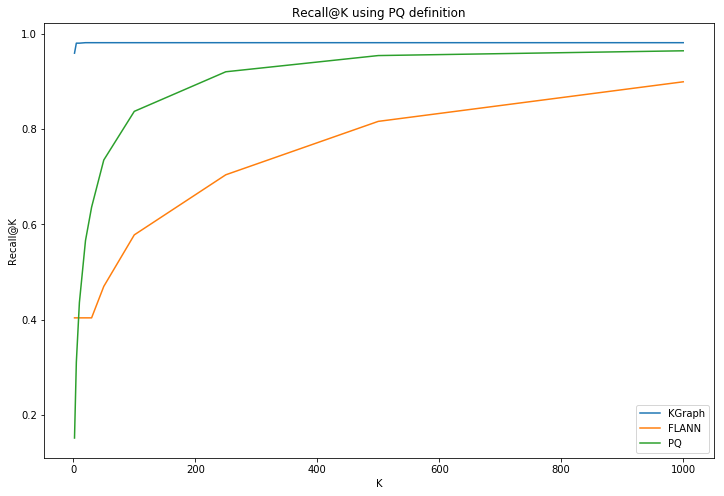

In [39]:
plt.figure(figsize=(12,8))
plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Recall@K using PQ definition")
plt.plot(kappas, recalls_kgraph2, label='KGraph')
plt.plot(kappas, recalls_flann2, label='FLANN')
plt.plot(kappas, recalls_pq2, label='PQ')
plt.legend()

In [53]:
index

NameError: name 'index' is not defined